In [1]:
def MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list):
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    J = np.ones((4,4), dtype = complex)
    
    P = np.zeros((4,4), dtype = complex)
    
    temp0 = np.array([[Uniform_zeta_list[which_layer][1][0], Uniform_zeta_list[which_layer][1][1], Uniform_mu_list[which_layer][1][0], Uniform_mu_list[which_layer][1][1]], [-Uniform_zeta_list[which_layer][0][0], -Uniform_zeta_list[which_layer][0][1], -Uniform_mu_list[which_layer][0][0], -Uniform_mu_list[which_layer][0][1]], [-Uniform_ep_list[which_layer][1][0], -Uniform_ep_list[which_layer][1][1], -Uniform_xi_list[which_layer][1][0], -Uniform_xi_list[which_layer][1][1]], [Uniform_ep_list[which_layer][0][0], Uniform_ep_list[which_layer][0][1], Uniform_xi_list[which_layer][0][0], Uniform_xi_list[which_layer][0][1]]])
    temp1 = np.diag((Uniform_zeta_list[which_layer][1][2]+kx0/omega, -Uniform_zeta_list[which_layer][0][2]+ky0/omega, -Uniform_ep_list[which_layer][1][2], Uniform_ep_list[which_layer][0][2]))
    temp2 = np.diag((nuzxee, nuzyee, nuzxeh, nuzyeh))
    
    temp3 = np.diag((Uniform_mu_list[which_layer][1][2], -Uniform_mu_list[which_layer][0][2], -Uniform_xi_list[which_layer][1][2]+kx0/omega, Uniform_xi_list[which_layer][0][2]+ky0/omega))
    temp4 = np.diag((nuzxhe, nuzyhe, nuzxhh, nuzyhh))
    
    P = omega*(temp0 + temp1 @ J @ temp2 + temp3 @ J @ temp4)
    
    return P


def Kmatrix(n, theta, phi):
    K   = np.array([[-np.sin(phi), -np.cos(phi)*np.cos(theta), -np.sin(phi), np.cos(phi)*np.cos(theta)], [np.cos(phi), -np.sin(phi)*np.cos(theta), np.cos(phi), np.sin(phi)*np.cos(theta)], [-n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi), n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi)], [-n/eta0*np.sin(phi)*np.cos(theta), -n1/eta0*np.cos(phi), n/eta0*np.sin(phi)*np.cos(theta), -n/eta0*np.cos(phi)]])
    
    return K
    
    
def MakeMMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    P = MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list)
    
    w, v = np.linalg.eig(P)

    expG = np.zeros((4, 4), dtype = complex)
    
    for i in range(4):
        expG[i, i] = np.exp(1j*w[i]*thickness_list[which_layer])
    
    M  = v @ expG @ np.linalg.inv(v)
    
    return M

def BandStructure(M, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q1    = np.log(w)/(1j*np.sum(thickness_list))
    q     = np.zeros(q1.shape, dtype = float)
    
    for j in range(4):
        if np.abs(np.imag(q1[j])/np.abs(q1[j])) < 1e-5:
            q[j] = np.real(q1[j])*np.sum(thickness_list)
        else:
            q[j] = None
    
    sort = np.argsort(q)
    q    = np.sort(q)
    
    return q, sort

def Electric(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    
    vex = np.zeros(4, dtype = complex)
    vey = np.zeros(4, dtype = complex)
    vez = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vex[i] = vsort[0,i]
        vey[i] = vsort[1,i]
        vez[i] = nuzxee*vsort[0,i]+nuzyee*vsort[1,i]+nuzxeh*vsort[2,i]+nuzyeh*vsort[3,i]
    
    return np.array([vex, vey, vez])

def Magnetic(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    vhx = np.zeros(4, dtype = complex)
    vhy = np.zeros(4, dtype = complex)
    vhz = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vhx[i] = vsort[2,i]
        vhy[i] = vsort[3,i]
        vhz[i] = nuzxhe*vsort[0,i]+nuzyhe*vsort[1,i]+nuzxhh*vsort[2,i]+nuzyhh*vsort[3,i]
    
    return np.array([vhx, vhy, vhz])

def Fields(ve, vh, M, incoming, z_offset, x_offset, y_offset, kx0, ky0, thickness):
    
    
    # Suppose we want to find the field in t-th layer,
    # M - Transfer Matrix of the t-th layer, ve, vh - electric and magnetic field eigenvectors in t-th layer, 
    # thickness - thickness of the t-th layer
    
    w, v = np.linalg.eig(M)
    q    = BandStructure(M, thickness)
    
    Coef = np.linalg.inv(v) @ incoming
    
    eh = []
    
    for j in range(len(z_offset)):
        ex = 0; ey = 0; ez = 0; hx = 0; hy = 0; hz = 0
        
        for i in range(4):
            ex += ve[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ey += ve[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ez += ve[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            
            hx += vh[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hy += vh[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hz += vh[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
        
        eh.append([[ex, ey, ez], [hx, hy, hz]])
    
    return eh


def RandT(M):
    r  = np.zeros((2,2), dtype = complex)
    t  = np.zeros((2,2), dtype = complex)
    
    det = (M[2,2]*M[3,3] - M[2,3]*M[3,2])
    
    r[0, 0] = (M[2, 3]*M[3,0]-M[2,0]*M[3,3])/det
    r[0, 1] = (M[2, 3]*M[3,1]-M[2,1]*M[3,3])/det
    r[1, 0] = (M[2, 0]*M[3,2]-M[3,0]*M[2,2])/det
    r[1, 1] = (M[2, 1]*M[3,2]-M[3,1]*M[2,2])/det
    
    t[0, 0] = ((M[0, 2]*M[2, 3]-M[0, 3]*M[2, 2])*M[3, 0]+(M[0, 3]*M[2,0]-M[0,0]*M[2, 3])*M[3,2]+(M[0,0]*M[2,2]-M[0, 2]*M[2,0])*M[3,3])/det
    t[0, 1] = M[0, 1] + ((M[0,2]*M[2,3]-M[0, 3]*M[2,2])*M[3,1]+(M[0, 3]*M[3, 2]-M[0, 2]*M[3,3])*M[2,1])/det
    t[1, 0] = ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,0]+(M[1,3]*M[2,0]-M[1,0]*M[2,3])*M[3,2]+(M[1,0]*M[2,2]-M[1,2]*M[2,0])*M[3,3])/det
    t[1, 1] = M[1,1] + ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,1]+(M[1,3]*M[3,2]-M[1,2]*M[3,3])*M[2,1])/det
    
    return r, t
    
def RefTrans(r, t, theta, n1, n2):
    Rss = np.abs(r[0,0])**2
    Rsp = np.abs(r[0,1])**2
    Rps = np.abs(r[1,0])**2
    Rpp = np.abs(r[1,1])**2
    
    thetar  = np.arcsin(n1*np.sin(theta)/n2)
    
    Tss = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,0])**2
    Tsp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,1])**2
    Tps = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,0])**2
    Tpp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,1])**2
    
    As = 1 - (Rss+Rps+Tss+Tps)
    Ap = 1 - (Rpp+Rsp+Tpp+Tsp)
    
    return Rss, Rsp, Rps, Rpp, Tss, Tsp, Tps, Tpp, As, Ap

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def EnDensity(weps, wmu, wgamma, elec1, elec2, mag1, mag2):
    
    coef1 = 1/2*(np.dot(np.conjugate(elec1), weps @ elec1)+np.dot(np.conjugate(mag1), wmu @ mag1)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag1)))
    
    coef2 = 1/2*(np.dot(np.conjugate(elec2), weps @ elec2)+np.dot(np.conjugate(mag2), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec2), wgamma @ mag2)))
        
    elec1 = elec1/np.sqrt(coef1)
    mag1 = mag1/np.sqrt(coef1)
    elec2 = elec2/np.sqrt(coef2)
    mag2 = mag2/np.sqrt(coef2)
    
    
    res   = 1/2*(np.dot(np.conjugate(elec1), weps @ elec2)+np.dot(np.conjugate(mag1), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag2)))
        
    return res

def EnDensity3(weps1, weps2, weps3, wmu1, wmu2, wmu3, elec11, elec12, elec13, elec21, elec22, elec23, mag11, mag12, mag13, mag21, mag22, mag23):
    
    coef11 = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec11)+np.dot(np.conjugate(mag11), wmu1 @ mag11))
    coef12 = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec12)+np.dot(np.conjugate(mag12), wmu2 @ mag12))
    coef13 = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec13)+np.dot(np.conjugate(mag13), wmu3 @ mag13))
    
    coef21 = 1/2*(np.dot(np.conjugate(elec21), weps1 @ elec21)+np.dot(np.conjugate(mag21), wmu1 @ mag21))
    coef22 = 1/2*(np.dot(np.conjugate(elec22), weps2 @ elec22)+np.dot(np.conjugate(mag22), wmu2 @ mag22))
    coef23 = 1/2*(np.dot(np.conjugate(elec23), weps3 @ elec23)+np.dot(np.conjugate(mag23), wmu3 @ mag23))
        
    elec11 = elec11/np.sqrt(coef11+coef12+coef13)
    elec12 = elec12/np.sqrt(coef11+coef12+coef13)
    elec13 = elec13/np.sqrt(coef11+coef12+coef13)
    mag11  = mag11/np.sqrt(coef11+coef12+coef13)
    mag12  = mag12/np.sqrt(coef11+coef12+coef13)
    mag13  = mag13/np.sqrt(coef11+coef12+coef13)
                  
    elec21 = elec21/np.sqrt(coef21+coef22+coef23)
    elec22 = elec22/np.sqrt(coef21+coef22+coef23)
    elec23 = elec23/np.sqrt(coef21+coef22+coef23)
    mag21  = mag21/np.sqrt(coef21+coef22+coef23)
    mag22  = mag22/np.sqrt(coef21+coef22+coef23)
    mag23  = mag23/np.sqrt(coef21+coef22+coef23)
    
    
    res1   = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec21)+np.dot(np.conjugate(mag11), wmu1 @ mag21))
    res2   = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec22)+np.dot(np.conjugate(mag12), wmu2 @ mag22))
    res3   = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec23)+np.dot(np.conjugate(mag13), wmu3 @ mag23))
                  
    return res1+res2+res3

In [2]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 10000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 0.65*np.pi*c/length, m)
n1      = 1
n2      = 1
phi1    = 0.



omega_p = 0.5*np.pi*c/length

kx0     = 0.
ky0     = 0.

    
# material parameters


q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    epsA = np.array([[2.2, -1j*0.2, 0], [+1j*0.2, 2.2, 0], [0, 0, 1 - (omega_p/omega[i])**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
    
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot)]
    Uniform_mu_list = [muA, rot @ muA @ np.linalg.inv(rot)]
    Uniform_xi_list = [xiA, rot @ xiA @ np.linalg.inv(rot)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot)]
    thickness_list  = [dA/2, dA/2]
    
    M1 = MakeMMatrix(omega[i], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega[i], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    # M3 = MakeMMatrix(omega[i], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
        
    q1[i], sort  = BandStructure(M2 @ M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

(-3.141592653589793, 3.141592653589793)

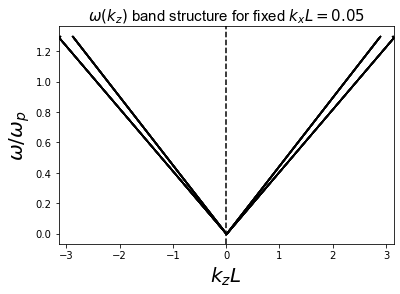

In [3]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

plt.title(r'$\omega(k_z)$ band structure for fixed $k_x L = 0.05$', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$k_z L$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\omega/\omega_p$", fontsize = 20)
plt.scatter(q1[:, 0], omega/omega_p,s = 0.1, marker='.',  color = "black")
plt.scatter(q1[:, 1], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 2], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 3], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-np.pi, np.pi])

In [4]:
find_nearest(omega, omega_p)

(470890794384584.56, 7691)

In [5]:
q1[7691,3]

2.4333530158838563

In [6]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
#phi     = np.linspace(0, 2*np.pi, 11)
#theta   = np.linspace(0, np.pi, 1001)
phi1    = 0.

dk      = 2221.44


kx0     = np.linspace(-dk, dk, 1001)
ky0     = 0.


omega   = (1-1e-3)*omega_p

q1      = np.zeros((len(kx0), 4), dtype = float)

for j in range(len(kx0)):
        
    epsA = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
        
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot)]
    Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot)]
    Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot)]
    thickness_list    = [dA/2, dA/2]

    M1 = MakeMMatrix(omega, 0, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega, 1, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    #M3 = MakeMMatrix(omega, 2, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
    q1[j], sort = BandStructure(M2 @ M1, thickness_list)

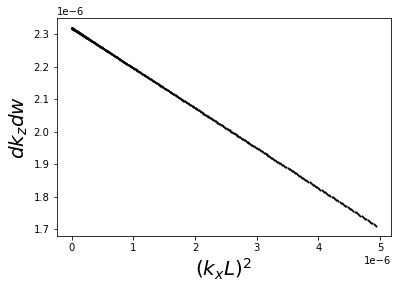

In [7]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.xlabel(r"$(k_x L)^2$", fontsize = 20)
plt.scatter((kx0*length)**2, (q1[:,3]-2.4333530158838563)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

In [8]:
(q1[:,3]-2.4333530158838563)

array([-0.00171028, -0.00171272, -0.00171515, ..., -0.00171515,
       -0.00171272, -0.00171028])

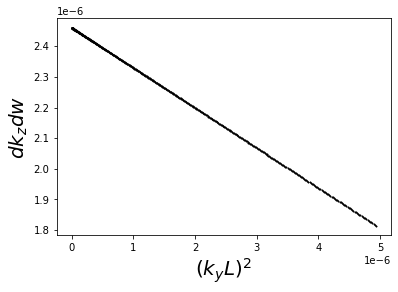

In [12]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.xlabel(r"$(k_y L)^2$", fontsize = 20)
plt.scatter((ky0*length)**2, (q1[:,3]-2.5809606278283224)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

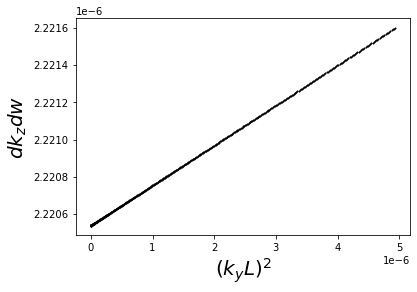

In [54]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.xlabel(r"$(k_y L)^2$", fontsize = 20)
plt.scatter((ky0*length)**2, (q1[:,3]-2.3297581401478435)*(omega/omega_p-1),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

In [14]:
np.polyfit((ky0*length)**2, -(q1[:,3]-2.5809606278283224)*1e-3, 1)

array([-1.30678328e-01,  2.46000560e-06])

In [9]:
np.polyfit((kx0*length)**2, -(q1[:,3]-2.4333530158838563)*1e-3, 1)

array([-1.23368190e-01,  2.31940199e-06])

In [38]:
np.polyfit((omega/omega_p-1), (q1[:,3]-2.4333530158838563), 1)

array([2.43346721e+00, 1.14189700e-04])

In [10]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.001*np.pi, 0.999*np.pi, 1001)
phi1    = 0.
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44

beta    = 2.43346721e+00
alpha1  = 1.23368190e-01
alpha2  = 1.23368190e-01
a1      = 1.23368190e-01
a2      = 1.23368190e-01

ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)


weps1   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

dw      = np.zeros((len(theta), len(phi)), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        epsA = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)

for j in range(len(theta)):
    
    
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))

        
for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        epsA = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)



for j in range(len(theta)):
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry2[j] = berry2[j] - np.imag(np.log(inner))

<ipython-input-10-0603d1f9588d>:68: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
<ipython-input-10-0603d1f9588d>:134: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[2.2, -1j*0.2, 0], [1j*0.2, 2.2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0


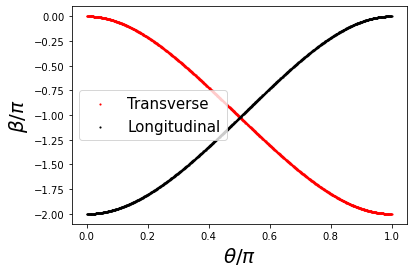

In [11]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, (berry1)/np.pi,s = 5, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 5, marker='.',  color = "black")
plt.legend(['Transverse', 'Longitudinal'], fontsize=15)

In [33]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 10000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 1.5*np.pi*c/length, m)
n1      = 1
n2      = 1
phi1    = 0.



omega_p = 0.5*np.pi*c/length
Omega   = 0.8*omega_p

kx0     = 0.
ky0     = 0.

    
# material parameters


q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    exx  = 1 - omega_p**2/(omega[i]**2 - Omega**2)
    exy  = -1j*Omega/omega[i]*(omega_p**2/(omega[i]**2 - Omega**2))
    epsA = np.array([[exx, -exy, 0], [exy, exx, 0], [0, 0, 1 - (omega_p/omega[i])**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
    
    
    Uniform_ep_list = [epsA]
    Uniform_mu_list = [muA]
    Uniform_xi_list = [xiA]
    Uniform_zeta_list = [zetA]
    thickness_list  = [dA]
    
    M1 = MakeMMatrix(omega[i], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        
    q1[i], sort  = BandStructure(M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

(-3.141592653589793, 3.141592653589793)

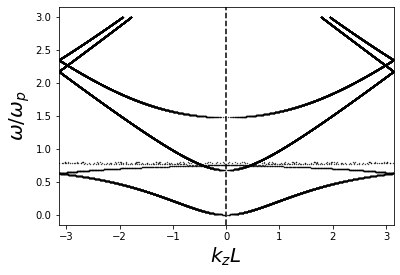

In [34]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

#plt.title(r'$\omega(k_z)$ band structure for fixed $k_x L = 0.05$', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$k_z L$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\omega/\omega_p$", fontsize = 20)
plt.scatter(q1[:, 0], omega/omega_p,s = 0.5, marker='.',  color = "black")
plt.scatter(q1[:, 1], omega/omega_p,s = 0.5, marker='.', color = "black")
plt.scatter(q1[:, 2], omega/omega_p,s = 0.5, marker='.', color = "black")
plt.scatter(q1[:, 3], omega/omega_p,s = 0.5, marker='.', color = "black")
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-np.pi, np.pi])

In [30]:
q1[7691,2]

1.1600225402392335

In [45]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
#phi     = np.linspace(0, 2*np.pi, 11)
#theta   = np.linspace(0, np.pi, 1001)
phi1    = 0.

dk      = 2221.44


kx0     = 0.
ky0     = 0.


omega   = np.linspace((1-1e-3)*omega_p, (1+1.1e-3)*omega_p, 1001)
Omega   = 1.2*omega_p

q1      = np.zeros((len(omega), 4), dtype = float)

for j in range(len(omega)):
    exx  = 1 - omega_p**2/(omega[j]**2 - Omega**2)
    exy  = -1j*Omega/omega[j]*(omega_p**2/(omega[j]**2 - Omega**2))        
    epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega[j])**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
        
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot)]
    Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot)]
    Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot)]
    thickness_list    = [dA/2, dA/2]

    M1 = MakeMMatrix(omega[j], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega[j], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    #M3 = MakeMMatrix(omega, 2, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
    q1[j], sort = BandStructure(M2 @ M1, thickness_list)

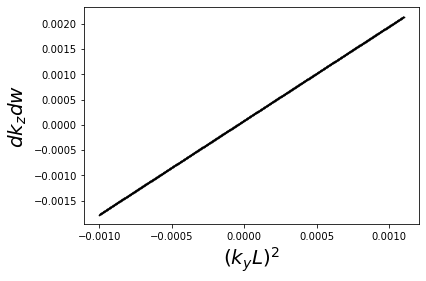

In [47]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.xlabel(r"$(k_y L)^2$", fontsize = 20)
plt.scatter((omega/omega_p-1), (q1[:,2]-1.1600225402392335),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

In [35]:
np.polyfit((kx0*length)**2, -(q1[:,2]-1.1600225402392335)*1e-3, 1)

array([-5.84568575e-02,  1.77607234e-06])

In [42]:
np.polyfit((ky0*length)**2, -(q1[:,2]-1.1600225402392335)*1e-3, 1)

array([ 5.90860064e-02, -1.95034238e-06])

In [48]:
np.polyfit((omega/omega_p-1), (q1[:,2]-1.1600225402392335), 1)

array([1.86317593e+00, 8.73166606e-05])

In [50]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.001*np.pi, 0.999*np.pi, 1001)
phi1    = 0.
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44
Omega   = 1.2*omega_p

beta    = 1.86317593e+00
alpha1  = 5.84568575e-02
alpha2  = 5.84568575e-02
a1      = 5.90860064e-02
a2      = 5.90860064e-02

ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)


weps1   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

dw      = np.zeros((len(theta), len(phi)), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        exx  = 1 - omega_p**2/(omega**2 - Omega**2)
        exy  = -1j*Omega/omega*(omega_p**2/(omega**2 - Omega**2)) 
        
        epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)

for j in range(len(theta)):
    
    
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))

        
for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        exx  = 1 - omega_p**2/(omega**2 - Omega**2)
        exy  = -1j*Omega/omega*(omega_p**2/(omega**2 - Omega**2)) 
        
        epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)



for j in range(len(theta)):
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry2[j] = berry2[j] - np.imag(np.log(inner))

<ipython-input-50-4c668342d8bb>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
<ipython-input-50-4c668342d8bb>:141: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0


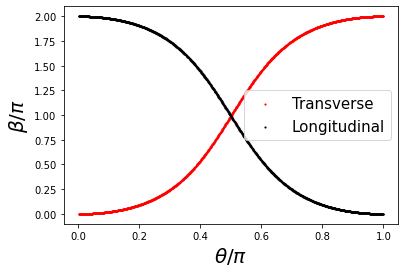

In [52]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, (berry1)/np.pi,s = 5, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 5, marker='.',  color = "black")
plt.legend(['Transverse', 'Longitudinal'], fontsize=15)

### for weaker magnetic field. Cycloton frequency $\omega_c = 0.2\omega_p$.

In [6]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 10000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 0.65*np.pi*c/length, m)
n1      = 1
n2      = 1
phi1    = 0.



omega_p = 0.5*np.pi*c/length
Omega   = .2*omega_p

kx0     = 0.
ky0     = 0.

    
# material parameters


q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    exx  = 1 - omega_p**2/(omega[i]**2 - Omega**2)
    exy  = -1j*Omega/omega[i]*(omega_p**2/(omega[i]**2 - Omega**2))
    epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega[i])**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
    
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot)]
    Uniform_mu_list = [muA, rot @ muA @ np.linalg.inv(rot)]
    Uniform_xi_list = [xiA, rot @ xiA @ np.linalg.inv(rot)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot)]
    thickness_list  = [dA/2, dA/2]
    
    M1 = MakeMMatrix(omega[i], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega[i], 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    # M3 = MakeMMatrix(omega[i], 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
        
    q1[i], sort  = BandStructure(M2 @ M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

(-3.141592653589793, 3.141592653589793)

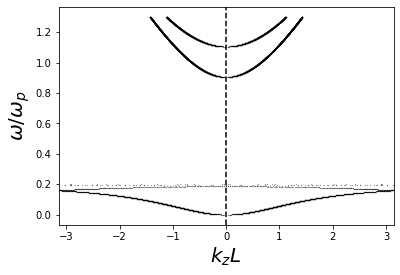

In [7]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

#plt.title(r'$\omega(k_z)$ band structure for fixed $k_x L = 0.05$', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$k_z L$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\omega/\omega_p$", fontsize = 20)
plt.scatter(q1[:, 0], omega/omega_p,s = 0.1, marker='.',  color = "black")
plt.scatter(q1[:, 1], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 2], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.scatter(q1[:, 3], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-np.pi, np.pi])

In [59]:
q1[7691, 1]

0.6411068862029584

In [78]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
#phi     = np.linspace(0, 2*np.pi, 11)
#theta   = np.linspace(0, np.pi, 1001)
phi1    = 0.

dk      = 2221.44


kx0     = 0.
ky0     = np.linspace(-dk, dk, 1001)


omega   = (1+1e-3)*omega_p
Omega   = .2*omega_p

q1      = np.zeros((len(ky0), 4), dtype = float)

for j in range(len(ky0)):
    exx  = 1 - omega_p**2/(omega**2 - Omega**2)
    exy  = -1j*Omega/omega*(omega_p**2/(omega**2 - Omega**2))        
    epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
    xiA  = np.zeros((3,3), dtype = complex)
    zetA = np.zeros((3,3), dtype = complex)
    dA   = length
        
    rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
    Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot)]
    Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot)]
    Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot)]
    Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot)]
    thickness_list    = [dA/2, dA/2]

    M1 = MakeMMatrix(omega, 0, kx0, ky0[j], Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    M2 = MakeMMatrix(omega, 1, kx0, ky0[j], Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
    #M3 = MakeMMatrix(omega, 2, kx0[j], ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
    q1[j], sort = BandStructure(M2 @ M1, thickness_list)

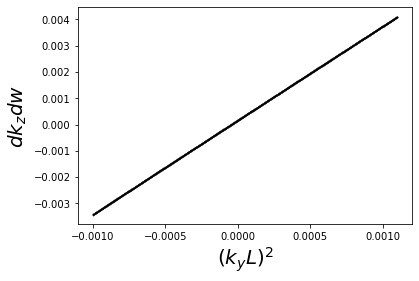

In [64]:
import matplotlib.pyplot as plt

plt.ylabel(r"$dk_zdw$", fontsize = 20)
plt.xlabel(r"$(k_y L)^2$", fontsize = 20)
plt.scatter((omega/omega_p-1), (q1[:,1]-0.6411068862029584),s = 2, marker='.',  color = "black")
#plt.plot((omega/omega_p-1)**2, (omega/omega_p-1)**2*0.5*np.pi*np.sqrt(2))

In [66]:
np.polyfit((omega/omega_p-1), (q1[:,1]-0.6411068862029584), 1)

array([3.57969593e+00, 1.65159129e-04])

In [68]:
np.polyfit((kx0*length)**2, -(q1[:,1]-0.6411068862029584)*1e-3, 1)

array([-3.19178813e-02,  3.42030976e-06])

In [79]:
np.polyfit((ky0*length)**2, -(q1[:,1]-0.6411068862029584)*1e-3, 1)

array([ 3.30516225e-02, -3.74068078e-06])

In [80]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
length  = 1e-6
omega_p = 0.5*np.pi*c/length
n1      = 1
n2      = 1
phi     = np.linspace(0, 2*np.pi, 11)
theta   = np.linspace(0.001*np.pi, 0.999*np.pi, 1001)
phi1    = 0.
thetar  = np.arcsin(n1*np.sin(theta)/n2)

dk      = 2221.44
Omega   = .2*omega_p

beta    = 3.57969593e+00
alpha1  = 3.19178813e-02
alpha2  = 3.19178813e-02
a1      = 3.30516225e-02
a2      = 3.30516225e-02

ve1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh1     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh2     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
ve3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)
vh3     = np.zeros((len(theta), len(phi), 3, 4), dtype = complex)

q1      = np.zeros((len(theta), len(phi), 4), dtype = float)


weps1   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps2   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)
weps3   = np.zeros((len(theta), len(phi), 3, 3), dtype = float)

dw      = np.zeros((len(theta), len(phi)), dtype = float)

for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length+np.sqrt((dkz*length)**2+4*alpha1*beta*(kx0*length)**2+4*alpha2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        exx  = 1 - omega_p**2/(omega**2 - Omega**2)
        exy  = -1j*Omega/omega*(omega_p**2/(omega**2 - Omega**2)) 
        
        epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)


    #inner[j, i] = Poynting(weps, Uniform_mu_list[0], Uniform_xi_list[0], ve1[i,:,0], ve1[:,0], vh1[:,0], vh1[:,0])

berry1 = np.zeros(len(theta), dtype = float)
berry2 = np.zeros(len(theta), dtype = float)

wmu   = mu0*np.eye(3)
wxi   = np.zeros((3,3))*1j*np.sqrt(mu0*eps0)

for j in range(len(theta)):
    
    
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry1[j] = berry1[j] - np.imag(np.log(inner))

        
for j in range(len(theta)):
    for i in range(len(phi)):
        
        kx0 = dk*np.sin(theta[j])*np.cos(phi[i])
        ky0 = dk*np.sin(theta[j])*np.sin(phi[i])
        dkz = dk*np.cos(theta[j])
        
        if dkz > 0:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        else:
            dw[j, i] = (dkz*length-np.sqrt((dkz*length)**2+4*a1*beta*(kx0*length)**2+4*a2*beta*(ky0*length)**2))/(2*beta)
        
        omega = (1+dw[j, i])*omega_p
        
        exx  = 1 - omega_p**2/(omega**2 - Omega**2)
        exy  = -1j*Omega/omega*(omega_p**2/(omega**2 - Omega**2)) 
        
        epsA = np.array([[exx, exy, 0], [-exy, exx, 0], [0, 0, 1 - (omega_p/omega)**2]])*eps0
        muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, 1.]])*mu0
        xiA  = np.zeros((3,3), dtype = complex)
        zetA = np.zeros((3,3), dtype = complex)
        dA   = length
        
        rot  = np.array([[np.cos(phi1), -np.sin(phi1), 0], [np.sin(phi1), np.cos(phi1), 0], [0, 0, 1]])
    
        weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
        weps2[j][i]  = rot @ weps1[j][i] @ np.linalg.inv(rot)
        weps3[j][i]  = matrix_power(rot, 2) @ weps1[j][i] @ matrix_power(rot, -2)
        
        Uniform_ep_list = [epsA, rot @ epsA @ np.linalg.inv(rot), matrix_power(rot, 2) @ epsA @ matrix_power(rot, -2)]
        Uniform_mu_list   = [muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2)]
        Uniform_xi_list   = [xiA, rot @ xiA @ np.linalg.inv(rot), matrix_power(rot, 2) @ xiA @ matrix_power(rot, -2)]
        Uniform_zeta_list = [zetA, rot @ zetA @ np.linalg.inv(rot), matrix_power(rot, 2) @ zetA @ matrix_power(rot, -2)]
        thickness_list    = [dA/3, dA/3, dA/3]

        M1 = MakeMMatrix(omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M2 = MakeMMatrix(omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        M3 = MakeMMatrix(omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
 
    
        q1[j, i], sort = BandStructure(M3 @ M2 @ M1, thickness_list)


        ve1[j, i] = Electric(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh1[j, i] = Magnetic(M3 @ M2 @ M1, omega, 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve2[j, i] = Electric(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh2[j, i] = Magnetic(M3 @ M2 @ M1, omega, 1, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        ve3[j, i] = Electric(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
        vh3[j, i] = Magnetic(M3 @ M2 @ M1, omega, 2, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)



for j in range(len(theta)):
    for i in range(len(phi)-1):
        
        inner = EnDensity3(weps1[j][i], weps2[j][i], weps3[j][i], muA, rot @ muA @ np.linalg.inv(rot), matrix_power(rot, 2) @ muA @ matrix_power(rot, -2),  ve1[j,i,:,3], ve2[j,i,:,3], ve3[j,i,:,3], ve1[j,i+1, :,3], ve2[j,i+1, :,3], ve3[j,i+1, :,3], vh1[j,i,:,3], vh2[j,i,:,3], vh3[j,i,:,3], vh1[j,i+1, :,3], vh2[j,i+1, :,3], vh3[j,i+1, :,3])
        
        berry2[j] = berry2[j] - np.imag(np.log(inner))

<ipython-input-80-bcb08929a261>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0
<ipython-input-80-bcb08929a261>:141: ComplexWarning: Casting complex values to real discards the imaginary part
  weps1[j][i]  = np.array([[1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 0], [-1j*2*Omega*omega*omega_p**2/(omega**2 - Omega**2)**2, 1+omega_p**2*(omega**2 + Omega**2)/(omega**2 - Omega**2)**2, 0], [0, 0, 1+omega_p**2/omega**2]])*eps0


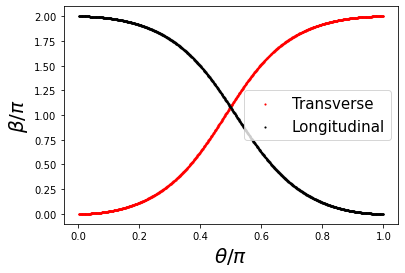

In [81]:
import matplotlib.pyplot as plt

plt.xlabel(r"$\theta/\pi$", fontsize = 20)
plt.ylabel(r"$\beta/\pi$", fontsize = 20)
plt.scatter(theta/np.pi, (berry1)/np.pi,s = 5, marker='.',  color = "red")
plt.scatter(theta/np.pi, berry2/np.pi,s = 5, marker='.',  color = "black")
plt.legend(['Transverse', 'Longitudinal'], fontsize=15)